In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import interpolate
from scipy import stats
from scipy import optimize
import networkx as nx
from sklearn import cluster
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [20]:
# load data
craft_num = 1
df = pd.read_csv(f'mercury_data_{craft_num}_clean.csv')
# some more cleaning
df = df.drop('Unnamed: 0', axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df['Pram'] = 1.67e-27 * df['np1'] * 100**3 * (df['vp1'] * 1e3)**2
df['absB'] = (df['Bx']**2 + df['By']**2 + df['Bz']**2)**0.5
df = df[(df['Pram'] != 0)]
# select time interval
begin = '1977-05-03 00:00:00'
end = '1977-05-03 23:59:59'
# df_select = df[(df['datetime'] >= begin) & (df['datetime'] <= end)]
# print(df_select)

if craft_num == 2:
    year_range = range(1976,1979+1)
else:
    year_range = range(1975,1981+1)

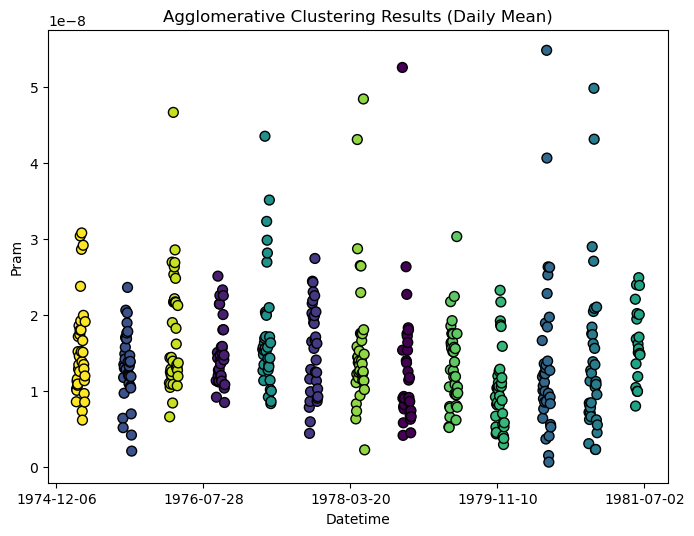

In [90]:
# Calculate daily mean of 'Pram' and store it in a new DataFrame
df['date'] = df['datetime'].dt.date
daily_mean = df.groupby('date')['Pram'].mean().reset_index()
daily_mean['date'] = pd.to_datetime(daily_mean['date'])  # Convert 'date' back to datetime
daily_mean['Days_Since_Given_Date'] = (daily_mean['date'] - daily_mean['date'].iloc[0]).dt.days
daily_mean_df = pd.concat([daily_mean['Days_Since_Given_Date'],daily_mean['Pram']],axis=1)

# Calculate hourly mean of 'Pram' and store it in a new DataFrame
# df['date-hour'] = df['datetime'].dt.strftime('%Y-%m-%d %H')
# daily_mean = df.groupby('date-hour')['Pram'].mean().reset_index()
# daily_mean['date-hour'] = pd.to_datetime(daily_mean['date-hour'])  # Convert 'date' back to datetime
# daily_mean['Hours_Since_Given_Date'] = (daily_mean['date-hour'] - daily_mean['date-hour'].iloc[0]).dt.total_seconds()/3600
# daily_mean_df = pd.concat([daily_mean['Hours_Since_Given_Date'],daily_mean['Pram']],axis=1)

# Cluster data
agg_clustering = cluster.AgglomerativeClustering(n_clusters=13,linkage='single')
daily_mean_df['cluster_label'] = agg_clustering.fit_predict(daily_mean_df)
daily_mean_df['date'] = daily_mean['date']

plt.figure(figsize=(8,6))
ax = plt.gca()
plt.scatter(daily_mean['date'], daily_mean_df['Pram'], c=daily_mean_df['cluster_label'], marker='o', edgecolor='black', s=50, cmap='viridis')
plt.title('Agglomerative Clustering Results (Daily Mean)')
plt.xlabel('Datetime')
plt.ylabel('Pram')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.show()

In [107]:
# KLD distance
def kld(time_series):
    kin_list = []
    kout_list = []
    n = len(time_series)
    for i in range(n):
        kin = 0
        kout= 0
        for j in range(i+1,n): # kout
            if time_series[j] < time_series[i]:
                kout += 1
            else:
                kout += 1
                break
        for k in range(i-1,-1,-1): # kin
            if time_series[k] < time_series[i]:
                kin += 1
            else:
                kin+=1
                break
        kin_list.append(kin)
        kout_list.append(kout)
    pin = []
    pout = []
    max_num = max([max(kin_list),max(kin_list)])
    for i in range(max_num):
        pin.append(kin_list.count(int(i))/len(kin_list))
    for i in range(max_num):
        pout.append(kout_list.count(int(i))/len(kout_list))
    # plt.figure()
    # plt.scatter(np.arange(0,len(pin),1),pin)
    # plt.scatter(np.arange(0,len(pout),1),pout)
    # plt.yscale('log')
    # plt.xlim(0,10)
    entropy = sum([pout[a]*np.log10(pout[a]/pin[a]) for a in range(len(pin)) if pin[a] != 0 and pout[a] != 0])
    return entropy

kld_param = 'vp1'
kld_list = [] 
chosen_dates = []
for i in daily_mean_df['date']:
    df_in_loop = df[(df['date'] == i)]
    chosen_dates.append(i)
    kld_value = kld(np.array(df_in_loop[kld_param]))
    kld_list.append(kld_value)
    # print(i, kld_value)
print(kld_list)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


[0.006040792798332711, -0.008609498454502651, 0.005609289909579684, 0.014402864617521874, 0.0011051977824328464, 0.004045653874756942, -0.0002048415534205398, 0.003606328578498925, 0.008540572150393659, 0.005722903712713697, 0.003695398823840598, 0.00659798487930754, 0.0037749644528094588, 0.006964748748488785, 0.006366906268767513, 0.014133096342766039, 0.022877083356465103, 0.007172849780759262, 0.012319762062144668, -5.059678982667986e-05, 0.008489858785507563, 0.010689709978499778, -0.0032739628561591445, 0.021375884193618862, 0.01673456523093892, 0.00995023537355073, 0.0065352975123049994, 0.01486028651172764, -0.003069582033683441, 0.016428562753995672, -0.0021191810190895593, 0.007031976513228769, -0.0005836085637679029, 0.010547495532065933, 0.012573543020575525, 0.002920224967693573, 0.08579548898919351, 0.1505149978319906, 0.0049190809440612625, 0.11346241887500379, -0.1101358257453004, 0.018559366735598767, -0.0374990010578775, 0.00726325156532212, 0.018298407920225097, 0.00

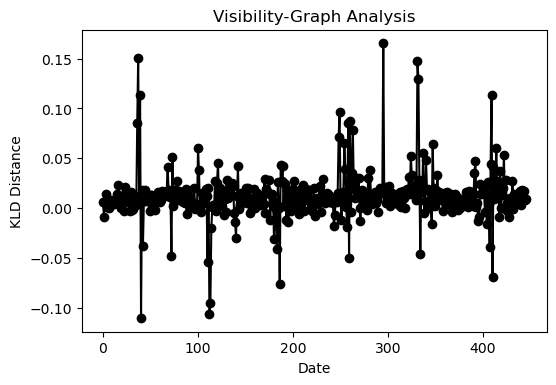

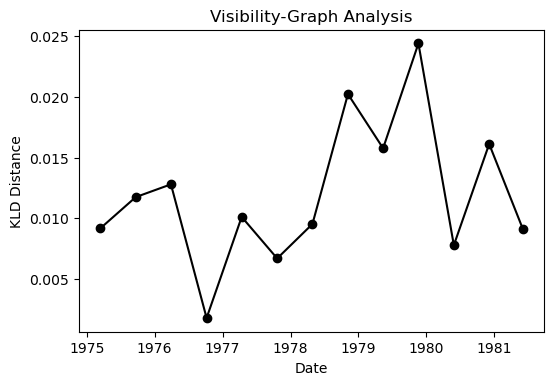

In [109]:
plt.figure()
plt.title('Visibility-Graph Analysis')
plt.ylabel('KLD Distance')
plt.xlabel('Date')
plt.plot(kld_list,'-o',color='black')
plt.show()

daily_mean_df['kld'] = kld_list
kld_mean = []
chosen_dates_mean = []
for i in daily_mean_df['cluster_label'].unique():
    df_in_loop = daily_mean_df[(daily_mean_df['cluster_label'] == int(i))]
    # df_in_loop = df_in_loop.drop('cluster_label', axis=1)
    chosen_dates_mean.append(df_in_loop['date'].mean())
    kld_mean.append(df_in_loop['kld'].mean())

plt.figure()
plt.title('Visibility-Graph Analysis')
plt.ylabel('KLD Distance')
plt.xlabel('Date')
plt.plot(chosen_dates_mean,kld_mean,'-o',color='black')
plt.show()

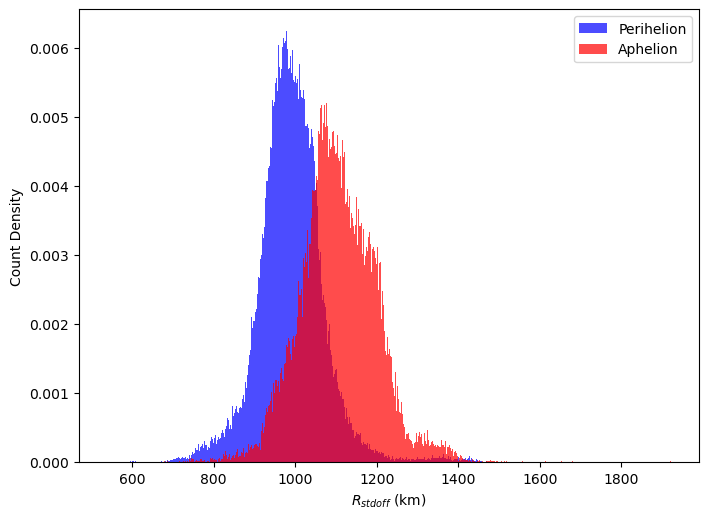

In [80]:
k_value = 50
df['Rstdoff'] = k_value * df['Pram']**(-1/6)

plt.figure(figsize=(8,6))
plt.xlabel(r'$R_{stdoff}$' +' (km)')
plt.ylabel('Count Density')
plt.hist(df[df['rh']<=0.33]['Rstdoff'],bins=1000,density=True,alpha=0.7,color='blue',label='Perihelion')
plt.hist(df[df['rh']>=0.44]['Rstdoff'],bins=1000,density=True,alpha=0.7,color='red',label='Aphelion')
plt.legend()
plt.show()


1975 Perhelion:
Alpha = 8.950e+01, Beta = 3.199e+02, a+b = 4.094e+02
1981 Perhelion:
Alpha = 7.430e+01, Beta = 2.332e+02, a+b = 3.075e+02
1975 Aphelion:
Alpha = 6.315e+01, Beta = 3.346e+02, a+b = 3.978e+02
1981 Aphelion:
Alpha = 9.070e+01, Beta = 1.553e+02, a+b = 2.460e+02


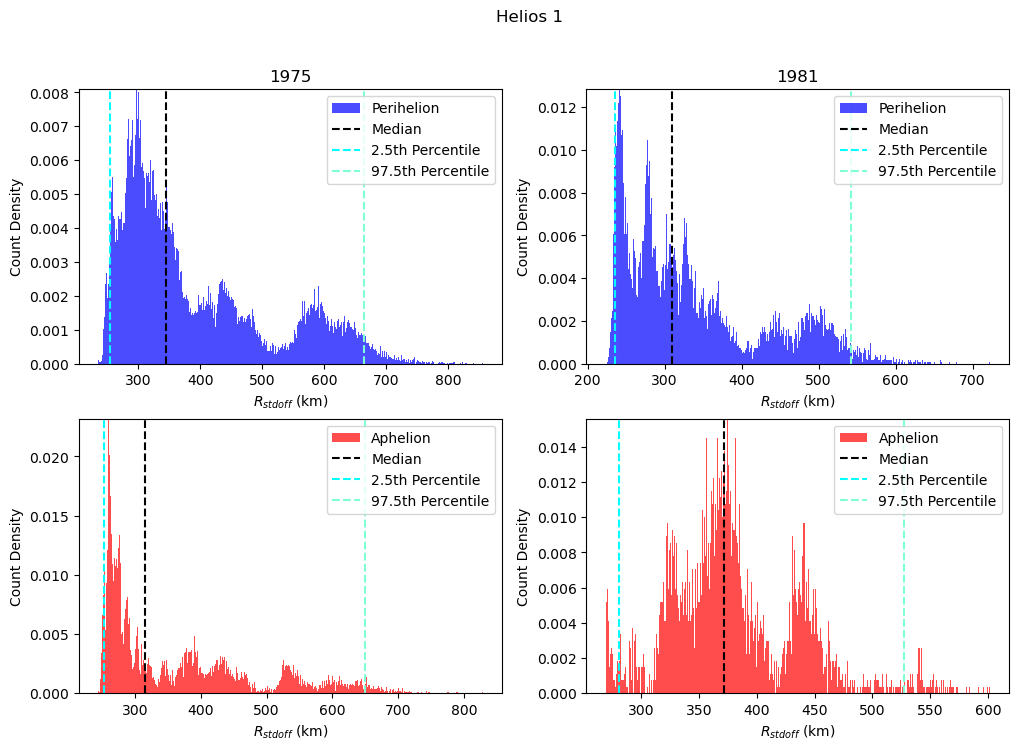

In [111]:

low_percentile = 0.025
high_percentile = 1-low_percentile

def spread_eval(data):
    # data must be a column in pandas dataframe
    median = data.median()
    top_5_percentile = data.quantile(high_percentile)
    bottom_5_percentile = data.quantile(low_percentile)
    alpha = median - bottom_5_percentile
    beta = top_5_percentile - median
    return [median,bottom_5_percentile,top_5_percentile,alpha,beta]
def plot_subplots_histogram(data,colour,year,den=True):
    # plt.grid()
    # plt.xlabel(r'$P_{ram}$' + ' (Pa)')
    plt.xlabel(r'$R_{stdoff}$' +' (km)')
    plt.ylabel('Count Density')
    if colour == 'blue':
        bin_height,bin_edges,_ = plt.hist(data,bins=500,density=den,alpha=0.7,color=colour,label='Perihelion')
        print(str(year) + ' Perhelion:')
    elif colour == 'red':
        bin_height,bin_edges,_ = plt.hist(data,bins=500,density=den,alpha=0.7,color=colour,label='Aphelion')
        print(str(year) + ' Aphelion:')
    plt.vlines(x=spread_eval(data=data)[0],ymin=0,ymax=10e8,color='black',linestyles='dashed',label='Median')
    plt.vlines(x=spread_eval(data=data)[1],ymin=0,ymax=10e8,color='aqua',linestyles='dashed',label=f'{(low_percentile*100)}th Percentile')
    plt.vlines(x=spread_eval(data=data)[2],ymin=0,ymax=10e8,color='aquamarine',linestyles='dashed',label=f'{(high_percentile*100)}th Percentile')
    plt.legend()
    # plt.xscale('log')
    # plt.xlim(1.5e-9,1e-7)
    # plt.xlim(700,1650)
    plt.ylim(0,max(bin_height))
    print('Alpha = %.3e, Beta = %.3e, a+b = %.3e' %(spread_eval(data=data)[-2],spread_eval(data=data)[-1],spread_eval(data=data)[-2]+spread_eval(data=data)[-1]))

plotvariable = 'vp1'
plt.figure(figsize=(12,8))
plt.suptitle('Helios 1')
plt.subplot(2,2,1)
plt.title('1975')
plot_subplots_histogram(df[(df['year'] == 1975) & (df['rh'] <= 0.33)][plotvariable],colour='blue',year='1975')
plt.subplot(2,2,2)
plt.title('1981')
plot_subplots_histogram(df[(df['year'] == 1981) & (df['rh'] <= 0.33)][plotvariable],colour='blue',year='1981')
plt.subplot(2,2,3)
plot_subplots_histogram(df[(df['year'] == 1975) & (df['rh'] >= 0.44)][plotvariable],colour='red',year='1975')
plt.subplot(2,2,4)
plot_subplots_histogram(df[(df['year'] == 1981) & (df['rh'] >= 0.44)][plotvariable],colour='red',year='1981')
plt.show()